### Training RNN using World's data

This is based on `COVID-19 growth prediction using multivariate
long short term memory` by `Novanto Yudistira`

https://arxiv.org/pdf/2005.04809.pdf

https://github.com/VICS-CORE/lstmcorona/blob/master/lstm.py

- We've aligned all countries' inputs rather than taking an absolute timeline. We start when number of confirmed cases in the country has crossed 100.
- We've normalised data by dividing by a population factor. That way the network can learn what factor of population will be affected.
- Rather than using the entire timeline as an input as suggested by NYudistira, we're training a fixed window (e.g. 20 days) so that the model learns to predict the future by looking at present data. The problem with fixed window approach is that some countries have peaked, while others have not. Also few countries start early, and some start late.

#### Ideas
- One idea is to train a network to predict SIR buckets
- Another is to train only with most populous countries

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

In [2]:
CUDA="cuda:0"
CPU="cpu"
device = torch.device(CUDA if torch.cuda.is_available() else CPU)
print(device)

cpu


### Read OWID data

In [3]:
!head -n1 csv/owid-covid-data.csv

iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k


In [4]:
cols = ['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'population']
dates = ['date']
df = pd.read_csv("csv/owid-covid-data.csv", 
                 usecols=cols,
                 parse_dates=dates)
df.sample()

,location,date,total_cases,new_cases,total_deaths,new_deaths,population
18658,Tunisia,2020-04-06,553,58,19,1,11818618.0


### Prepare dataset

In [5]:
IP_SEQ_LEN = 20
OP_SEQ_LEN = 10
VAL_RATIO = 0.3

def gen_dataset():
    ip_trn = []
    op_trn = []

    countries = df['location'].unique()
    pop_countries = ['China', 'United States', 'Indonesia', 'Pakistan', 'Brazil', 'Bangladesh', 'Russia', 'Mexico']
    c = 0
    for country in countries:
        if country in ['World', 'International', 'India']: # Countries to be skipped
            continue
        country_df = df.loc[df.location == country]
        tot_cases_gt_100 = (country_df['total_cases'] >= 100)
        country_df = country_df.loc[tot_cases_gt_100]

        if len(country_df) >= IP_SEQ_LEN + OP_SEQ_LEN:
            c += 1
            pop = country_df['population'].iloc[0]
            print(c, country, len(country_df), pop)
            daily_cases = np.array(country_df['new_cases'].rolling(7, center=True, min_periods=1).mean() * 1000 / pop, dtype=np.float32)

            for i in range(len(country_df) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
                ip_trn.append(daily_cases[i : i+IP_SEQ_LEN])
                op_trn.append(daily_cases[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])

    ip_trn = torch.from_numpy(np.array(ip_trn, dtype=np.float32))
    op_trn = torch.from_numpy(np.array(op_trn, dtype=np.float32))
    dataset = tdt.TensorDataset(ip_trn, op_trn)

    val_len = int(VAL_RATIO * len(dataset))
    trn_len = len(dataset) - val_len
    trn_set, val_set = tdt.random_split(dataset, (trn_len, val_len))
    return trn_set, val_set

try:
    ds = torch.load('ds.pt')
    trn_set, val_set = ds['trn'], ds['val']
    print("Loaded dataset from ds.pt")
except FileNotFoundError:
    trn_set, val_set = gen_dataset()
    torch.save({'trn': trn_set, 'val': val_set}, 'ds.pt')
    print("Saved dataset to ds.pt")
finally:
    print("Training data:", len(trn_set), "Validation data:", len(val_set))

trn_loader = tdt.DataLoader(trn_set, shuffle=True, batch_size=1)
val_loader = tdt.DataLoader(val_set, shuffle=True, batch_size=1)

1 Aruba 37 106766.0
2 Afghanistan 62 38928341.0
3 Albania 67 2877800.0
4 Andorra 68 77265.0
5 United Arab Emirates 73 9890400.0
6 Argentina 71 45195777.0
7 Armenia 72 2963234.0
8 Australia 81 25499881.0
9 Austria 82 9006400.0
10 Azerbaijan 64 10139175.0
11 Belgium 84 11589616.0
12 Burkina Faso 65 20903278.0
13 Bangladesh 53 164689383.0
14 Bulgaria 71 6948445.0
15 Bahrain 81 1701583.0
16 Bosnia and Herzegovina 68 3280815.0
17 Belarus 60 9449321.0
18 Bermuda 33 62273.0
19 Bolivia 60 11673029.0
20 Brazil 76 212559409.0
21 Brunei 66 437483.0
22 Canada 79 37742157.0
23 Switzerland 84 8654618.0
24 Chile 74 19116209.0
25 China 132 1439323774.0
26 Cote d'Ivoire 63 26378275.0
27 Cameroon 60 26545864.0
28 Democratic Republic of Congo 58 89561404.0
29 Congo 44 5518092.0
30 Colombia 72 50882884.0
31 Cape Verde 33 555988.0
32 Costa Rica 70 5094114.0
33 Cuba 62 11326616.0
34 Cyprus 67 875899.0
35 Czech Republic 78 10708982.0
36 Germany 90 83783945.0
37 Djibouti 52 988002.0
38 Denmark 81 5792203.0
39

### LSTM

In [6]:
class YudistirNet(tnn.Module):
    def __init__(self, ip_seq_len=1, op_seq_len=1, hidden_size=1, num_layers=1):
        super(YudistirNet, self).__init__()
        
        self.ip_seq_len = ip_seq_len
        self.op_seq_len = op_seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = tnn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.linear = tnn.Linear(self.hidden_size * self.ip_seq_len, self.op_seq_len)
        self.sigmoid = tnn.Sigmoid()
    
    def forward(self, ip):
        lstm_out, _ = self.lstm(ip)
        linear_out = self.linear(lstm_out.view(self.hidden_size * self.ip_seq_len))
        sigmoid_out = self.sigmoid(linear_out.view(self.op_seq_len))
        return sigmoid_out
    
    def predict(self, ip):
        with torch.no_grad():
            preds = self.forward(ip)
        return preds

### Checkpoint

In [7]:
def save_checkpoint(epoch, model, optimizer, trn_losses, val_losses, min_val_loss, path=""):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'trn_losses': trn_losses,
        'val_losses': val_losses,
        'min_val_loss': min_val_loss
    }, path or "latest.pt")
    print("Checkpoint saved")
    
def load_checkpoint(path="", device="cpu"):
    cp = torch.load(path or "latest.pt", map_location=device)
    print("Checkpoint loaded")
    return cp['epoch'], cp['model_state_dict'], cp['optimizer_state_dict'], cp['trn_losses'], cp['val_losses'], cp.get('min_val_loss', np.Inf)

### Train

In [8]:
HIDDEN_SIZE = 10
NUM_LAYERS = 4
LEARNING_RATE = 0.001
NUM_EPOCHS = 2001

model = YudistirNet(ip_seq_len=IP_SEQ_LEN, op_seq_len=OP_SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
model = model.to(device)

loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=LEARNING_RATE)

trn_loss_vals = []
val_loss_vals = []
e = 0
min_val_loss = np.Inf

# Enable resume to load saved model for training
resume = False
if resume:
    e, model_dict, optimizer_dict, trn_loss_vals, val_loss_vals, min_val_loss = load_checkpoint(device=device)
    e+=1
    model.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)

# TRAIN
print("BEGIN: [", dt.datetime.now(), "]")
while e < NUM_EPOCHS:
    model.train()
    trn_losses = []
    for data in trn_loader:
        ip, op = data
        ip = ip.to(device)
        op = op.to(device)
        optimizer.zero_grad() # set grads to 0
        preds = model(ip.view(IP_SEQ_LEN, 1, 1)) # predict
        loss = loss_fn(preds, op.view(OP_SEQ_LEN)) # calc loss
        loss.backward() # calc and assign grads
        optimizer.step() # update weights
        trn_losses.append(loss) # logging
    avg_trn_loss = torch.stack(trn_losses).mean().item() * 10000
    trn_loss_vals.append(avg_trn_loss)
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for data in val_loader:
            ip, op = data
            ip = ip.to(device)
            op = op.to(device)
            preds = model(ip.view(IP_SEQgen_dataset, 1, 1))
            loss = loss_fn(preds, op.view(OP_SEQ_LEN))
            val_losses.append(loss)
        avg_val_loss = torch.stack(val_losses).mean().item() * 10000
        val_loss_vals.append(avg_val_loss)
    
    if e%10==0:
        print("[", dt.datetime.now(), "] epoch:", f"{e:3}", "avg_val_loss:", f"{avg_val_loss: .5f}", "avg_trn_loss:", f"{avg_trn_loss: .5f}")
        save_checkpoint(e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss)
        if avg_val_loss <= min_val_loss:
            min_val_loss = avg_val_loss
            save_checkpoint(e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss, "best.pt")
    e+=1
print("END: [", dt.datetime.now(), "]")

df_trn_loss = pd.DataFrame({
    'trn_loss': trn_loss_vals,
    'val_loss': val_loss_vals
})
_ = df_trn_loss.plot(
    y=['trn_loss', 'val_loss'],
    title=['Training loss per epoch', 'Validation loss per epoch'],
    subplots=True,
    figsize=(5,8),
    sharex=False,
    logy=True
)

BEGIN: [ 2020-05-31 17:29:02.227344 ]
[ 2020-05-31 17:30:36.753202 ] epoch:   0 avg_val_loss:  22.61383 avg_trn_loss:  33.40665
Checkpoint saved
Checkpoint saved
[ 2020-05-31 17:47:27.228211 ] epoch:  10 avg_val_loss:  3.70301 avg_trn_loss:  2.62507
Checkpoint saved
Checkpoint saved
[ 2020-05-31 18:03:34.428543 ] epoch:  20 avg_val_loss:  2.50847 avg_trn_loss:  1.99543
Checkpoint saved
Checkpoint saved
[ 2020-05-31 18:19:54.375498 ] epoch:  30 avg_val_loss:  1.91389 avg_trn_loss:  1.42405
Checkpoint saved
Checkpoint saved
[ 2020-05-31 18:36:24.068958 ] epoch:  40 avg_val_loss:  1.70523 avg_trn_loss:  1.28395
Checkpoint saved
Checkpoint saved
[ 2020-05-31 18:52:49.833233 ] epoch:  50 avg_val_loss:  1.66171 avg_trn_loss:  1.12632
Checkpoint saved
Checkpoint saved
[ 2020-05-31 19:08:43.842325 ] epoch:  60 avg_val_loss:  1.50077 avg_trn_loss:  1.05665
Checkpoint saved
Checkpoint saved
[ 2020-05-31 19:24:18.808978 ] epoch:  70 avg_val_loss:  1.69408 avg_trn_loss:  0.94356
Checkpoint saved
[

### Load saved model for evaluation

In [ ]:
_, md, _, _, _, _ = load_checkpoint("models/IP20_OP10_H10_L4_E1111_LR001.pt", device=device)
HIDDEN_SIZE = 10
NUM_LAYERS = 4
model = YudistirNet(ip_seq_len=IP_SEQ_LEN, op_seq_len=OP_SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
model = model.to(device)
model.load_state_dict(md)
model.eval()

### Evalute fit

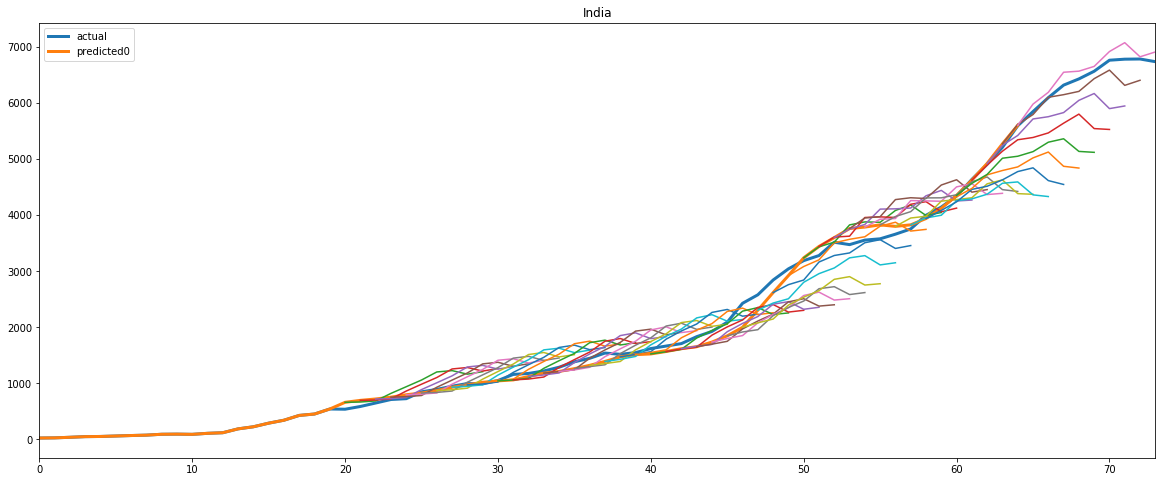

In [9]:
c = "India"
pop_fct = df.loc[df.location==c, 'population'].iloc[0] / 1000

all_preds = []
pred_vals = []
out_vals = []

test_data = np.array(df.loc[(df.location==c) & (df.total_cases>=100), 'new_cases'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

for i in range(len(test_data) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
    ip = torch.tensor(test_data[i : i+IP_SEQ_LEN])
    op = torch.tensor(test_data[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])
    ip = ip.to(device)
    op = op.to(device)

    pred = model.predict(ip.view(IP_SEQ_LEN, 1, 1))    
    if i==0: # prepend first input
        pred_vals.extend(ip.view(IP_SEQ_LEN).cpu().numpy() * pop_fct)
        out_vals.extend(ip.view(IP_SEQ_LEN).cpu().numpy() * pop_fct)        
    all_preds.append(pred.view(OP_SEQ_LEN).cpu().numpy() * pop_fct)
    pred_vals.append(pred.view(OP_SEQ_LEN).cpu().numpy()[0] * pop_fct)
    out_vals.append(op.view(OP_SEQ_LEN).cpu().numpy()[0] * pop_fct)

# last N-1 values
out_vals.extend(op.view(OP_SEQ_LEN).cpu().numpy()[1:] * pop_fct)
pred_vals.extend(([np.NaN] * OP_SEQ_LEN)[1:]) # pad with NaN

cmp_df = pd.DataFrame({
    'actual': out_vals,
    'predicted0': pred_vals
})
ax = cmp_df.plot(
    figsize=(20,8),
    lw=3,
    title=c
)

# plot predictions
i=IP_SEQ_LEN
for pred in all_preds:
    cmp_df['predicted_cases'] = np.NaN
    cmp_df.loc[i:i+OP_SEQ_LEN-1, 'predicted_cases'] = pred
    cmp_df.plot(y='predicted_cases', ax=ax, legend=False)
    i+=1

### Test (predict)

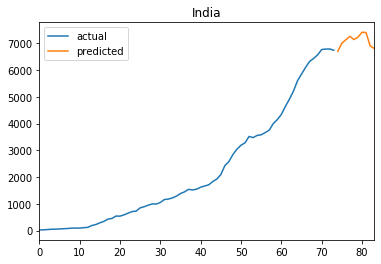

In [10]:
c = "India"
pop_fct = df.loc[df.location==c, 'population'].iloc[0] / 1000
test_data = np.array(df.loc[(df.location==c) & (df.total_cases>=100), 'new_cases'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

ip = torch.tensor(
    test_data[-IP_SEQ_LEN:],
    dtype=torch.float32
)
ip = ip.to(device)
pred = model.predict(ip.view(IP_SEQ_LEN, 1, 1))
orig_df = pd.DataFrame({
    'actual': test_data * pop_fct
})
fut_df = pd.DataFrame({
    'predicted': pred.cpu().numpy() * pop_fct
})
orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
_ = orig_df.plot(title=c)